/tmp/ipython-input-237875406.py:115: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


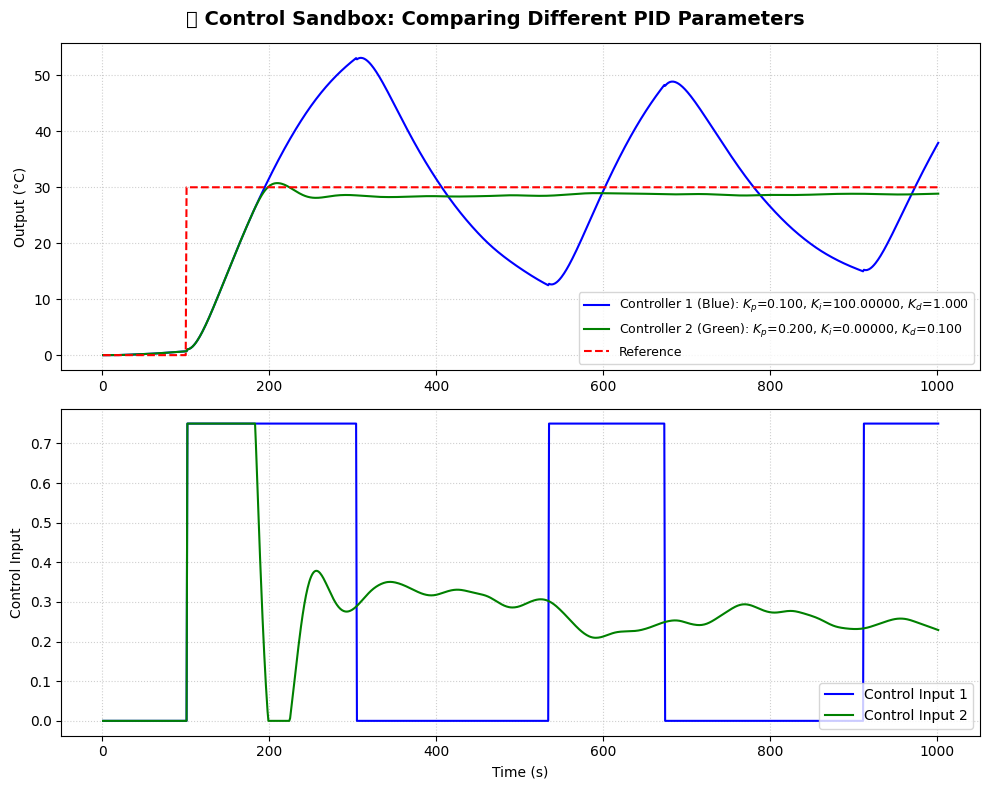

In [8]:
# @title Press the run button to load simulation environment
# Cell 1: PID Simulation Tuner Setup and GUI Display
# Metadata changed

from IPython.display import display, Javascript, clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import ipywidgets as widgets
import os
import sys

# Define the main function that contains all the logic, setup, and GUI display
def setup_pid_tuner_and_run():
    """
    Encapsulates all data loading, simulation logic, plotting, and GUI setup.
    It returns the GUI widgets and executes the code-hiding script.
    """

    # --- 1. DATA LOADING AND SYSTEM PARAMETERS ---
    data_filename = 'prbs_test_18_Jun_2025_13_50_02.mat'

    # Download the data file if it's not present (Colab environment assumes wget works)
    if not os.path.exists(data_filename):
        print("Downloading data file...")
        os.system('wget -O prbs_test_18_Jun_2025_13_50_02.mat https://raw.githubusercontent.com/AlasMac/TCLab-Python-Resources/main/prbs_test_18_Jun_2025_13_50_02.mat')
        if not os.path.exists(data_filename):
            print("Error: Could not download or find the required .mat data file.")
            return None # Exit function if file is missing

    try:
        data = loadmat(data_filename)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    T = data['T']
    U = data['U']
    y_data_test = T[0, :]
    y_data_test = y_data_test - y_data_test[0]
    u_data_test = U[0, :]

    # --- Model parameters ---
    A = [1, -3.88098254, 5.64726905, -3.6515443, 0.88525793]
    B = [0.4453368, -1.71110786, 2.49838163, -1.64272524, 0.41012833]
    k = 0
    sigma = 1e-5

    # --- Setpoint ---
    N = len(u_data_test)
    r = np.zeros(N, dtype=float)
    r[100:] = 30 # Step change in setpoint
    u_thresh = 0.75 # Control Input Saturation Limit
    y0 = y_data_test[0]

    system_params = {
        'A': A, 'B': B, 'k': k, 'sigma': sigma, 'N': N,
        'r': r, 'u_thresh': u_thresh, 'y0': y0
    }

    # --- 2. CORE SIMULATION AND PLOTTING FUNCTIONS ---

    def ARX_Sim_PID(A, B, k, Kp, Ki, Kd, r, mu, sigma, SIM_TIME, x0, u_thresh):
        """Simulates an ARX model with PID control (same as original)."""
        t = np.arange(1, SIM_TIME + 1)
        rng = np.random.default_rng(seed=100)
        e = rng.normal(mu, sigma, size=len(t))
        na, nb = len(A), len(B)
        L = max(na, nb)

        if na > nb: B = np.concatenate([B, np.zeros(na - nb)])
        elif nb > na: A = np.concatenate([A, np.zeros(nb - na)])

        ut = np.zeros(len(t) + L)
        y = np.ones(len(t) + L) * x0
        err = np.zeros_like(y)
        integral_err = 0
        alpha = 0.5
        dt = 1.0

        for i in range(L + k, SIM_TIME):
            y[i] = -np.dot(A[1:], y[i - 1 : i - na : -1]) + np.dot(B, ut[i - k : i - nb - k : -1]) + e[i]
            err[i] = r[i] - y[i]
            integral_err += err[i] * dt
            d_err = err[i] - err[i - 1]
            ut[i + 1] = (Kp * err[i] + Ki * integral_err + Kd * (alpha * d_err / dt + (1 - alpha) * d_err))
            ut[i + 1] = np.clip(ut[i + 1], 0, u_thresh)

        return y[: -L], ut[: -L], t

    def plot_sandbox(t, y, u, t2, y2, u2, r, Kp1, Ki1, Kd1, Kp2, Ki2, Kd2):
        """Plots the results of the two simulations for comparison."""
        try: plt.close('all')
        except: pass

        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        fig.suptitle('🌡️ Control Sandbox: Comparing Different PID Parameters', fontsize=14, fontweight='bold')

        label1 = f'Controller 1 (Blue): $K_p$={Kp1:.3f}, $K_i$={Ki1:.5f}, $K_d$={Kd1:.3f}'
        label2 = f'Controller 2 (Green): $K_p$={Kp2:.3f}, $K_i$={Ki2:.5f}, $K_d$={Kd2:.3f}'

        axes[0].plot(t, y, 'b', label=label1)
        axes[0].plot(t2, y2, 'g', label=label2)
        axes[0].plot(t, r, '--r', label='Reference')
        axes[0].set_ylabel('Output (°C)')
        axes[0].legend(loc='lower right', fontsize=9)
        axes[0].grid(True, linestyle=':', alpha=0.6)

        axes[1].plot(t, u, 'b', label='Control Input 1')
        axes[1].plot(t2, u2, 'g', label='Control Input 2')
        axes[1].set_ylabel('Control Input')
        axes[1].set_xlabel('Time (s)')
        axes[1].legend(loc='lower right')
        axes[1].grid(True, linestyle=':', alpha=0.6)

        plt.tight_layout()
        plt.show()

    # --- 3. INTERACTIVE LOGIC AND GUI SETUP ---

    # Define initial widget values
    Kp1_default, Ki1_default, Kd1_default = 0.1, 0.0003, 0.25
    Kp2_default, Ki2_default, Kd2_default = 0.2, 0.0, 0.1

    # Setup Widgets
    style = {'description_width': 'initial', 'handle_color': 'lightblue'}
    Kp1_widget = widgets.FloatText(value=Kp1_default, description='Kp 1:', style=style)
    Ki1_widget = widgets.FloatText(value=Ki1_default, description='Ki 1:', style=style)
    Kd1_widget = widgets.FloatText(value=Kd1_default, description='Kd 1:', style=style)

    style2 = {'description_width': 'initial', 'handle_color': 'lightgreen'}
    Kp2_widget = widgets.FloatText(value=Kp2_default, description='Kp 2:', style=style2)
    Ki2_widget = widgets.FloatText(value=Ki2_default, description='Ki 2:', style=style2)
    Kd2_widget = widgets.FloatText(value=Kd2_default, description='Kd 2:', style=style2)

    # Define the button callback function
    def run_simulation(b):
        clear_output(wait=True)
        display(input_box) # Re-display the GUI

        Kp1, Ki1, Kd1 = Kp1_widget.value, Ki1_widget.value, Kd1_widget.value
        Kp2, Ki2, Kd2 = Kp2_widget.value, Ki2_widget.value, Kd2_widget.value

        try:
            params = system_params
            # Run simulations
            y1, u1, t1 = ARX_Sim_PID(params['A'], params['B'], params['k'], Kp1, Ki1, Kd1, params['r'], 0, params['sigma'], params['N'], params['y0'], params['u_thresh'])
            y2, u2, t2 = ARX_Sim_PID(params['A'], params['B'], params['k'], Kp2, Ki2, Kd2, params['r'], 0, params['sigma'], params['N'], params['y0'], params['u_thresh'])

            # Plot results
            plot_sandbox(t1, y1, u1, t2, y2, u2, params['r'], Kp1, Ki1, Kd1, Kp2, Ki2, Kd2)

        except Exception as e:
            print(f"Error during simulation: {e}")

    # Setup the button
    button = widgets.Button(description="🚀 Run Simulation (Compare)",
                            button_style='success',
                            layout=widgets.Layout(width='auto', height='40px'))
    button.on_click(run_simulation)

    # Layout organization
    ctrl1_label = widgets.Label(value="🔵 Controller 1 Gains")
    ctrl1_box = widgets.VBox([ctrl1_label, Kp1_widget, Ki1_widget, Kd1_widget])
    ctrl2_label = widgets.Label(value="🟢 Controller 2 Gains")
    ctrl2_box = widgets.VBox([ctrl2_label, Kp2_widget, Ki2_widget, Kd2_widget])

    input_box = widgets.HBox([ctrl1_box, widgets.VBox([widgets.Label(value=''), button]) , ctrl2_box],
                             layout=widgets.Layout(justify_content='space-around'))

    return input_box


# --- FINAL FUNCTION CALLS (Minimal code visible to the user) ---

# Run the entire setup function
main_input_box = setup_pid_tuner_and_run()

if main_input_box:
    # 1. Display the GUI
    print("Adjust the controller gains below and press the button to compare the results.")
    display(main_input_box)

    # 2. Hide the entire code cell input area using JavaScript
    # This targets the currently running cell to collapse its code input
    display(Javascript("""
      var cells = Jupyter.notebook.get_cells();
      var current_cell_index = cells.indexOf(Jupyter.notebook.get_selected_cell());
      var target_cell = cells[current_cell_index];

      if (target_cell) {
        target_cell.collapse_input();
      }
    """))
